In [1]:
from matplotlib import pyplot as plt

In [2]:
# will return bandwidth in Bytes/sec.
def convBandwidth(input):
    if input[-4:] == "Mbps" : return ((10**6) * float(input[:-4]))/8
    elif input[-4:] == "MBps" : return (10**6) * float(input[:-4])
    elif input[-3:] == "Bps" : return float(input[:-3])
    elif input[-3:] == "bps"    : return float(input[:-3])/8
    else:
        print("conversion not supported")
        return -1

# will return time in sec.
def convTime(input):
    if input[-2:] == "ms" : return (10**(-3) * float(input[:-2]))
    elif input[-1:] == "s" : return float(input[:-1])
    elif input[-3:] == "sec" : return float(input[:-3])
    else:
        print("conversion not supported")
        return -1

# values_dict is a time series data dictionary
def plotvstime(values_dict, xlabel, ylabel, title):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    plt.plot(values_dict.keys(), values_dict.values())
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
def plotvstime_n(values_dict_n, xlabel, ylabel, title, n_flows):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    for i in range(n_flows):
        plt.plot(values_dict_n[i].keys(), values_dict_n[i].values())
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
def plotvstime_n_avg(values_dict_n, xlabel, ylabel, title, n_flows):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    avg_values = {}
    for t in values_dict_n[0].keys():
        
        temp_sum = 0
        for i in range(n_flows):
            temp_sum = temp_sum + values_dict_n[i][t]
            
        avg_values[t] = temp_sum/n_flows
        #print(avg_values)
   
    plt.plot(avg_values.keys(), avg_values.values())
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.title(title)
    
def plotvstime_avg_each_flow(values_dict_n, xlabel, ylabel, title, n_flows):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    value_each_flow = {}
    
    for i in range(n_flows):
        value_each_flow[i+1]= sum(values_dict_n[i].values())/len(values_dict_n[i].keys())
    
    plt.bar(value_each_flow.keys(), value_each_flow.values())
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.title(title)
        
    

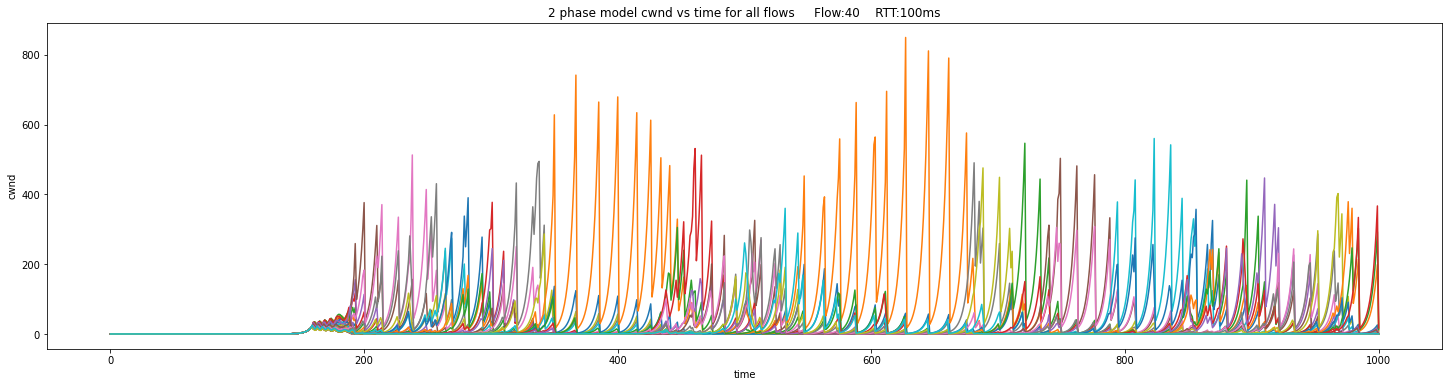

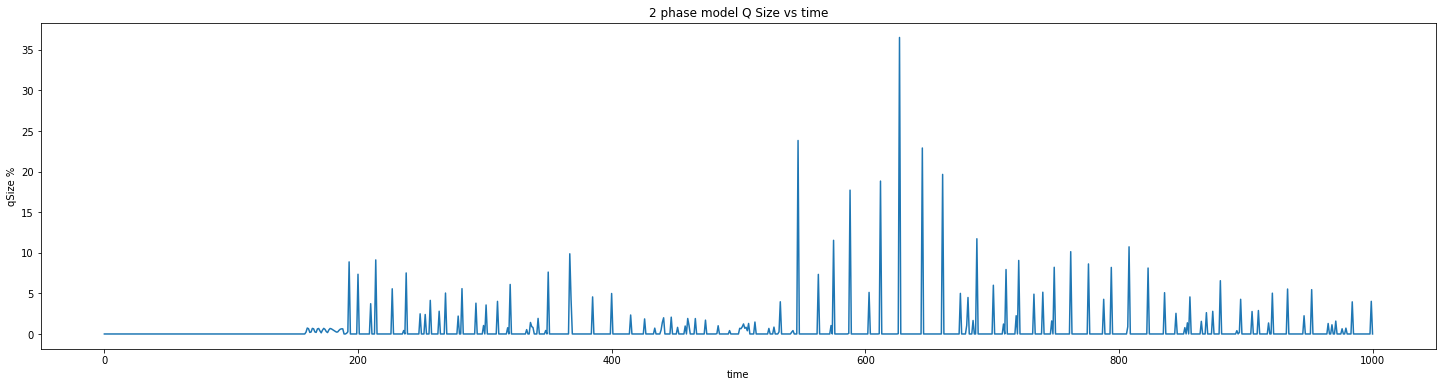

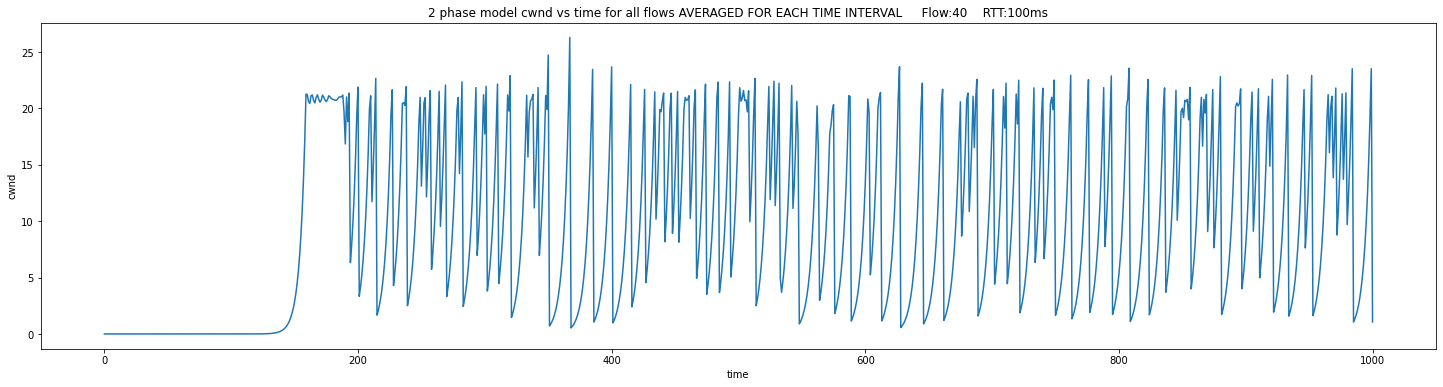

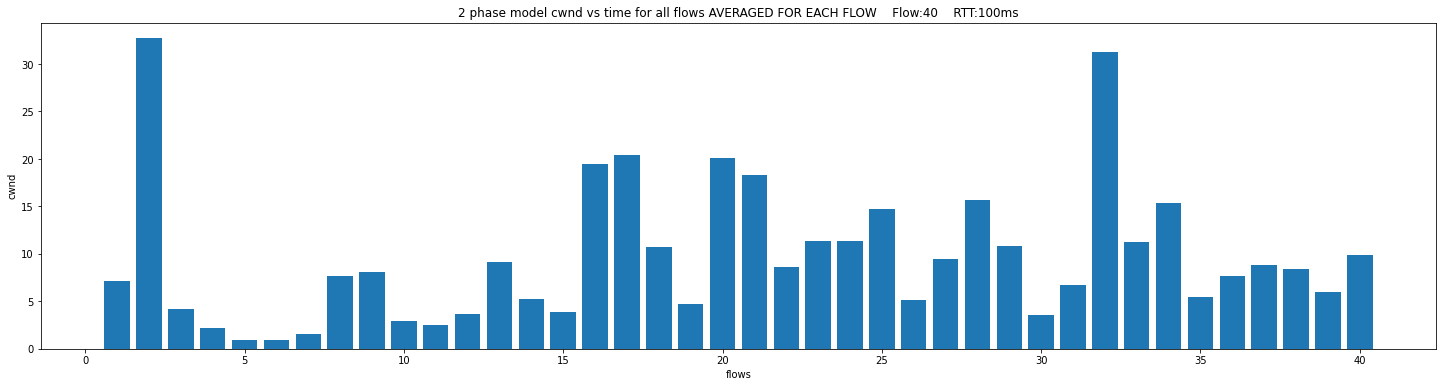

In [5]:
# Discrete time interval 
deltaTime_str = "1sec"
deltaTime = convTime(deltaTime_str)

class queueObj:
    maxSizeBytes = 0
    currSizeBytes = 0.00000000001 
    
    # will get updated after constructor call
    btlnkBandwidth = 1 
    queueingDelay = currSizeBytes/btlnkBandwidth
    
    def __init__(self, maxSizeBytes, btlnkBandwidth):
        self.maxSizeBytes = maxSizeBytes
        self.btlnkBandwidth = btlnkBandwidth
        
            
    def updateSize(self, nCwndSizeBytes, RTT):
        self.currSizeBytes = self.currSizeBytes + deltaTime*(sum(nCwndSizeBytes)/RTT - self.btlnkBandwidth)
        if self.currSizeBytes < 0 : self.currSizeBytes = 0
        
        self.queueingDelay = self.currSizeBytes/self.btlnkBandwidth

    
# Ti : RTT min for a flow i 
# D : Queueing delay for all flows    
def MIMD(qObj, Ti, D, phase_factor):
    # if the queue is 1/3rd( subject to change) filled, then bandwidth is underestimated i.e. pacing controlled
    if ( qObj.currSizeBytes < qObj.maxSizeBytes/phase_factor ): return (1.25 * Ti)/(Ti + D)
    # otherwise congestion window controlled
    else: return (2 * Ti)/(Ti + D)
    


def Simul():
    starttime = 0
    endtime = 1000

    
    
    pktsize = 1500
    queueL = "2084p"
    queueSizeBytes = pktsize*int(queueL[:-1])
    
    btlnkBandwidth_str = "100Mbps"
    btlnkBandwidth = convBandwidth(btlnkBandwidth_str)
    
    
    # We will decide the RTT
    RTT_str = "100ms"
    RTT = convTime(RTT_str)
    
    n_flows = 40
    phase_factor = 10
    nCwndSize = [0.00000000001]*n_flows
    
    
    # Creating a queue for the bottleneck link
    qobj = queueObj(queueSizeBytes, btlnkBandwidth)
    
    nCwndSizeStore = {}
    qSizeStore = {}
    
    
    currtime = starttime
    # simulation starts here
    while currtime <= endtime:
        
        for i in range(0,n_flows):
        
            nCwndSize[i] = nCwndSize[i] * MIMD(qobj, RTT, qobj.queueingDelay, phase_factor)       
            
            qobj.updateSize(nCwndSize, RTT)
            
            # storing the number of packets( 1 pkt = 1500 By ) in the congestion windows
            if i not in nCwndSizeStore.keys():
                nCwndSizeStore[i] = {}
                
            nCwndSizeStore[i][currtime] = nCwndSize[i]/1500
        
        # storing the qsize for plotting
        qSizeStore[currtime] = qobj.currSizeBytes/qobj.maxSizeBytes
        
        currtime = currtime + deltaTime
    
    # #plotting individually
    # for i in range(0,n_flows ):
    #     plotvstime(nCwndSizeStore[i], ylabel=f"cwnd {i+1}", xlabel="time", title = f"Congestion windows size vs time     RTT:{RTT_str}")    
    
    
    
    # plot in the same graph
    plotvstime_n(nCwndSizeStore, ylabel=f"cwnd", xlabel="time", title = f"2 phase model cwnd vs time for all flows     Flow:{n_flows}    RTT:{RTT_str}", n_flows=n_flows )
    
    plotvstime(qSizeStore, ylabel="qSize %", xlabel="time", title = "2 phase model Q Size vs time")
    
    plotvstime_n_avg(nCwndSizeStore, ylabel=f"cwnd", xlabel="time", title = f"2 phase model cwnd vs time for all flows AVERAGED FOR EACH TIME INTERVAL     Flow:{n_flows}    RTT:{RTT_str}", n_flows=n_flows )
            
    plotvstime_avg_each_flow(nCwndSizeStore, ylabel=f"cwnd", xlabel="flows", title = f"2 phase model cwnd vs time for all flows AVERAGED FOR EACH FLOW    Flow:{n_flows}    RTT:{RTT_str}", n_flows=n_flows )
Simul()

    
        